# Codon Usage Bias

### Kathleen Hablutzel
### BIO 334/335 Bioinformatics Final Project
##### Very, Very, Very rough draft

Originally submitted on December 5. This draft will continue to be updated as new viral data is collected. Additional annotation will also be added in the methods and results sections to walk through the code.

### Summary
This project compiles a database of the codon usage bias (CUB) of thousands of animals, plants, and viruses from the [NCBI RefSeq database](https://ftp.ncbi.nlm.nih.gov/genomes/refseq/). We visualize how organisms vary in CUB when we summarize variation in CUB in two dimensions. Next, we observe distinct though overlapping clusters among mammals, other vertebrates, and invertebrates when plotted by these principle components of CUB, as well as a separation into two visual clusters of so far unknown character. Based on these promising clusters, we build a classifier to predict whether a genome is vertebrate or invertebrate with 78% accuracy. Then, we incorporate a dataset on viral hosts to build a classifier of whether a virus infects humans or not. Despite a small sample size, we achieve a 72% accuracy at predicting whether a virus infects humans based on CUB alone. The success of this classifier suggests that CUB may be a useful predictor of whether a virus may infect humans, and could be potentially incorporated as a factor in models that predict emerging viral threats to the human species. Other potential applications of this project could recycle the NCBI RefSeq genome scraper to build datasets of any statistic about every RefSeq genome (or a subset thereof). Additionally, the CUB dataset from this work could be distributed for the convenience of bioinformaticians and machine learners alike, as no known dataset of CUB currently exists.

### Introduction
While organisms share the same genetic code nearly universally, tRNA availability causes a codon usage bias (CUB) which varies among organisms [3]. Codon usage patterns may also evolve over time in response to selective pressures; for example, viruses may favor the CUB of the host organism to maximize translational efficiency or become more dissimilar to the host’s CUB to avoid competition [1,2,4,5].

### Methods

Data analysis for this project fell into two stages: First, we collected transcriptomes of many sample organisms and calculated the codon usage bias for each organism. Second, we will apply machine learning methods to group and identify organisms based on the codon usage bias. All code developed for this project will be available in this [publicly available Github repository](https://github.com/krhablutzel/codon-usage-bias).

For the data collection phase of this project, we access the coding sequence (CDS) regions of each organism’s representative reference genome, as available in the NCBI reference genome database. We utilize the CDS regions because they always start in the correct reading frame and include only the exons of the genome, allowing for easy conversion into codons for calculation of codon usage bias. For most (if not all) organisms in the database, all CDS regions of the genome are available in a compressed fasta format at [https://ftp.ncbi.nlm.nih.gov/genomes/refseq/{taxon}/{species}/{representative}/{genBank}/{genBank}_cds_from_genomic.fna.gz](https://ftp.ncbi.nlm.nih.gov/genomes/refseq/), where:
- taxon is the refseq taxonomic directory in which the species is located, such as vertebrate_mammalian, bacteria, or viral,
- species is the binomial species name of a species, or a viral name for a virus, 
- representative contains animal/plant reference sequences, or latest_assembly_version contains the refseq for viruses, and
- genBank is the GenBank assembly accession identifier, concatenated with the name of the assembly.

For example, the most recent Felis catus assembly is at GenBank accession number GCA_000181335.5, and the corresponding CDS of the genome is available at https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_mammalian/Felis_catus/representative/GCF_000181335.3_Felis_catus_9.0/GCF_000181335.3_Felis_catus_9.0_cds_from_genomic.fna.gz. Due to the standard naming convention of these CDS files, we have developed a script (currently available here) to automatically access and unzip the CDS fasta files for all species in a given taxonomic directory, which will be much more efficient than downloading the files one-by-one. This script could also be applied to all the species in a given list of target organisms, to obtain a smaller sample than an entire directory. We provide the option to download every genome to the user's local machine, though we discourage this for large amounts of genomes due to the memory storage required. Thus, we also provide an option to access each genome, calculate CUB, then abandon the genome in memory rather than storing it.

Once we have obtained the fasta files for all CDS regions of each organism’s genome, we will use the Biopython library to concatenate the CDS regions into one single sequence for each organism. We concatenate CDS regions into one single CDS genome because we plan to calculate codon usage bias across the entire genome for each organism—however, future work could explore how CUB varies at different regions of a genome. Additionally, we exclude CDS regions which do not start with the near-universal start codon (AUG) and regions whose length is not a multiple of 3, to stay as true to open reading frames as possible.

From this CDS genome, we calculated the codon usage bias for each organism and recorded this information in a dataframe alongside species name, taxon, genome length, and the GenBank accession number of the reference genome.

Below is the code which imports the codon usage bias dataframe, as generated from running [generate_data.py](https://github.com/krhablutzel/codon-usage-bias/blob/main/generate_data.py) from the project repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# all my helper functions
from helper import *

In [2]:
# load data
bias_pd = pd.read_csv("datasets/all_taxa_cub.csv")
bias_pd.shape

(8993, 68)

In [3]:
bias_pd.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,AGA,AGG,GGU,GGC,GGA,GGG,AccessionNum,SeqLen,Species,Taxon
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,...,0.20,0.2,0.125,0.125000,0.375000,0.375,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,...,0.00,0.0,0.000,0.200000,0.000000,0.800,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,...,0.20,0.2,0.125,0.250000,0.375000,0.250,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,...,0.30,0.3,0.500,0.000000,0.500000,0.000,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,...,0.25,0.5,0.000,0.166667,0.333333,0.500,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian


### Results

In [4]:
# summarize entire dataset in 2d
bias_2d = reduce_dim(bias_pd, dim=2, vertebrate=False)

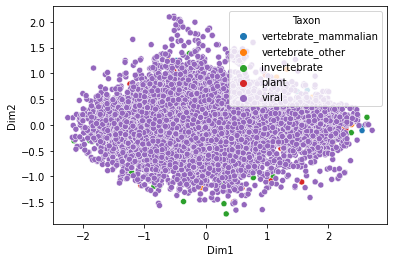

In [5]:
# plot of all CUB in the dataset - overwhelmed by the number of viruses vs. other organisms
sns.scatterplot(data=bias_2d, x='Dim1', y='Dim2', hue='Taxon');

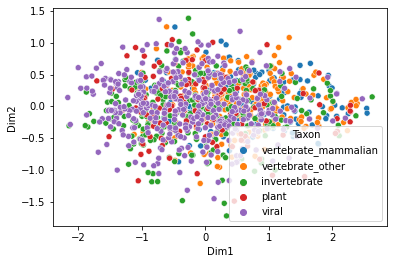

In [6]:
# plot with fewer viruses - still hard to see any meaningful differences
sns.scatterplot(data=bias_2d.head(1200), x='Dim1', y='Dim2', hue='Taxon');

### Clustering Animals - CUB differences among taxa?
We see more of a clustering by CUB if we just look at animals.

In [7]:
# get dataset of just animals
is_animal = (bias_pd["Taxon"] == "vertebrate_mammalian") | (bias_pd["Taxon"] == "vertebrate_other") | \
            (bias_pd["Taxon"] == "invertebrate")
a_bias = bias_pd[is_animal].copy()
# label as vertebrate or invertebrate
# https://datatofish.com/if-condition-in-pandas-dataframe/
a_bias["Vertebrate"] = a_bias["Taxon"].apply(lambda x: 0 if (x == "invertebrate") else 1)
a_bias.shape

(675, 69)

In [83]:
a_bias[['AUG', 'GGC', 'GGA', 'GGG', 'Vertebrate']]

,AUG,GGC,GGA,GGG,Vertebrate
0,1.0,0.125000,0.375000,0.375000,1
1,1.0,0.200000,0.000000,0.800000,1
2,1.0,0.250000,0.375000,0.250000,1
3,1.0,0.000000,0.500000,0.000000,1
4,1.0,0.166667,0.333333,0.500000,1
...,...,...,...,...,...
670,1.0,1.000000,0.000000,0.000000,0
671,1.0,0.166667,0.333333,0.500000,0
672,1.0,0.333333,0.666667,0.000000,0
673,1.0,0.125000,0.375000,0.000000,0


In [8]:
a_bias.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,AGG,GGU,GGC,GGA,GGG,AccessionNum,SeqLen,Species,Taxon,Vertebrate
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,...,0.2,0.125,0.125000,0.375000,0.375,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,1
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,...,0.0,0.000,0.200000,0.000000,0.800,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,1
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,...,0.2,0.125,0.250000,0.375000,0.250,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,1
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,...,0.3,0.500,0.000000,0.500000,0.000,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,1
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,...,0.5,0.000,0.166667,0.333333,0.500,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,1


In [147]:
def reduce_dim(data_pd, dim=2, vertebrate=True):
    # separate out numeric data
    if vertebrate:
        data_num = data_pd.drop(columns=["AccessionNum", "SeqLen", "Species",
                                         "Taxon", "UAA", "UAG", "UGA", "AUG", "UGG", "Vertebrate"]).to_numpy()
    else:
        data_num = data_pd.drop(columns=["AccessionNum", "SeqLen", "Species",
                                         "Taxon", "UAA", "UAG", "UGA", "AUG"]).to_numpy()

    # don't standardize numeric data
    # std vs norm vs [nothing]
    # data_std = normalize(data_num)
    # data_std = standardize(data_num)
    data_std = data_num

    # run PCA
    pca_alg = PCA(n_components=dim)
    if dim == 2:
        data_2d = pd.DataFrame(pca_alg.fit_transform(data_std), columns=["Dim1", "Dim2"])
    else:
        data_2d = pd.DataFrame(pca_alg.fit_transform(data_std), columns=["Dim1", "Dim2", "Dim3"])

    # add back metadata
    if vertebrate:
        metadata = data_pd[["AccessionNum", "SeqLen", "Species", "Taxon", "Vertebrate"]]
    else:
        metadata = data_pd[["AccessionNum", "SeqLen", "Species", "Taxon"]]
    data_2d_meta = pd.concat([data_2d, metadata], axis=1)

    return data_2d_meta

In [148]:
# summarize in 2d
a_bias_2d = reduce_dim(a_bias, dim=2)
a_bias_2d.head()

,Dim1,Dim2,AccessionNum,SeqLen,Species,Taxon,Vertebrate
0,-0.094550,-0.840267,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,1
1,-0.399652,0.107291,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,1
2,-0.121369,0.001907,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,1
3,0.681652,0.065340,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,1
4,1.109017,-0.085078,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,1


<IPython.core.display.Javascript object>


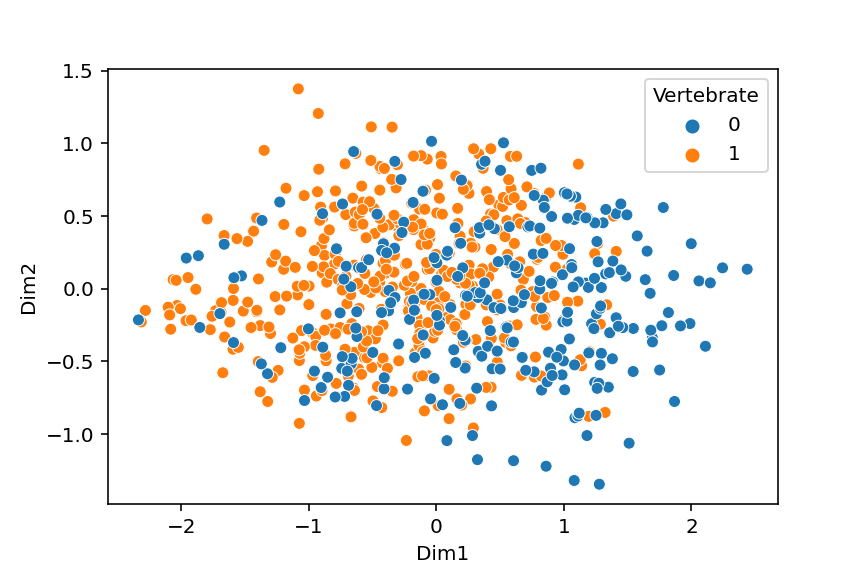

In [149]:
# nothing
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Vertebrate');

In [122]:
# summarize in 3d
a_bias_3d = reduce_dim(a_bias, dim=3)
a_bias_3d.head()

,Dim1,Dim2,Dim3,AccessionNum,SeqLen,Species,Taxon,Vertebrate
0,-0.109295,-0.663555,-0.730711,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,1
1,-0.413537,-0.365107,0.146000,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,1
2,-0.135093,-0.381658,0.101519,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,1
3,0.668326,-0.282949,0.169074,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,1
4,1.094101,-0.455557,0.012569,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,1


<IPython.core.display.Javascript object>


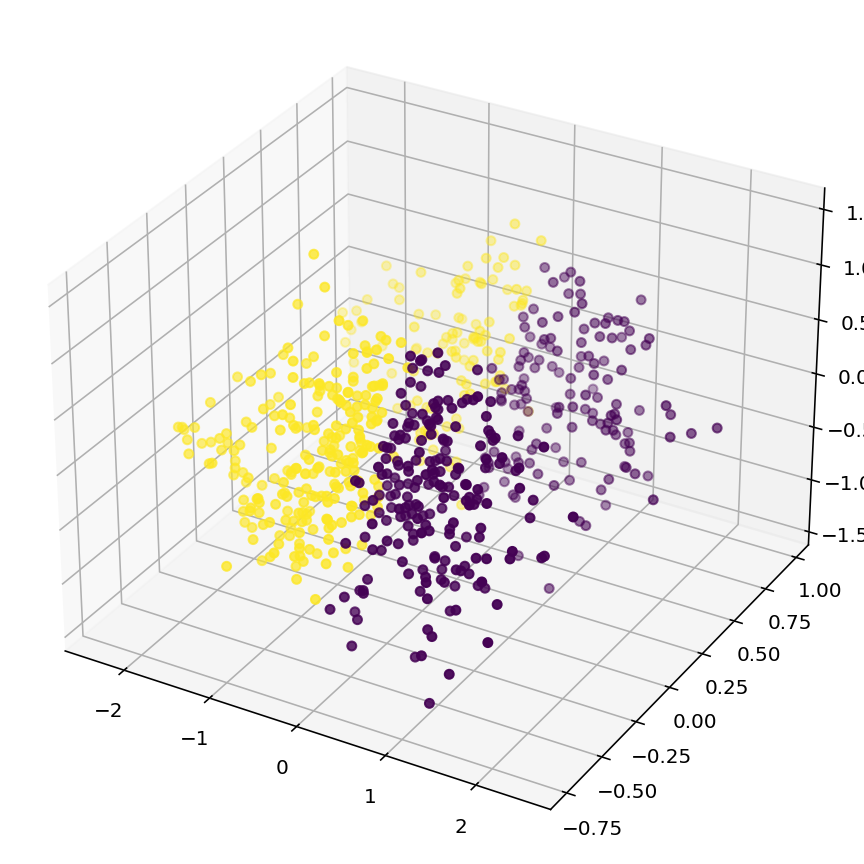

<ipython-input-123-826207697b05>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


In [123]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)
ax.scatter(a_bias_3d['Dim1'], a_bias_3d['Dim2'], a_bias_3d['Dim3'], c=labels)

<IPython.core.display.Javascript object>


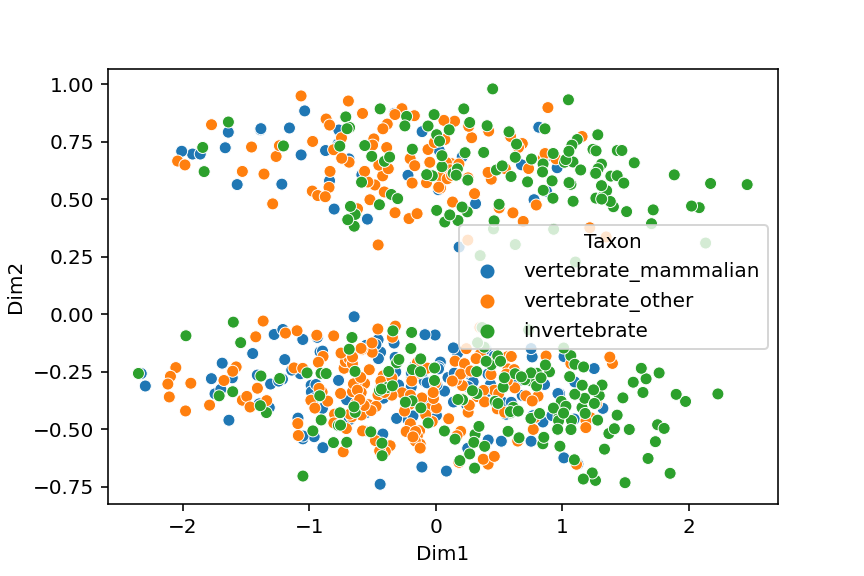

In [124]:
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Taxon');

It's strange that animals fall into two distinct clusters. I wonder what the distinction is—clearly it's not across our observed taxonomic boundaries. Let's try applying a clustering algorithm to animals based on codon bias, and we'll take a look at the resulting clusters.

### clustering animals by CUB

In [142]:
# create dataset with just CUB data
a_bias_num = a_bias.drop(columns=["AccessionNum", "SeqLen", "Species", "Taxon", "UAA", "UAG", "UGA", "AUG", "UGG", "Vertebrate"])

In [143]:
a_bias_num.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,GUU,GUC,GUA,GUG,UCU,UCC,UCA,UCG,AGU,AGC,CCU,CCC,CCA,CCG,ACU,ACC,ACA,ACG,GCU,GCC,GCA,GCG,UAU,UAC,CAU,CAC,CAA,CAG,AAU,AAC,AAA,AAG,GAU,GAC,GAA,GAG,UGU,UGC,CGU,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,0.333333,0.300000,0.100000,0.100000,0.500000,0.222222,0.444444,0.111111,0.000000,0.222222,0.000000,0.000000,0.444444,0.333333,0.222222,0.333333,0.333333,0.000000,0.333333,0.111111,0.444444,0.111111,0.333333,0.500000,0.500000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.600000,0.400000,1.0,0.0,0.4,0.6,0.000000,1.000000,0.2,0.0,0.00,0.4,0.20,0.2,0.125,0.125000,0.375000,0.375
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,0.142857,0.142857,0.714286,0.000000,0.142857,0.222222,0.333333,0.333333,0.000000,0.000000,0.111111,0.000000,0.666667,0.333333,0.000000,0.250000,0.500000,0.250000,0.000000,0.250000,0.375000,0.375000,0.000000,0.333333,0.666667,0.0,1.0,0.200000,0.800000,0.200000,0.800000,0.000000,1.000000,1.0,0.0,0.8,0.2,0.500000,0.500000,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.200000,0.000000,0.800
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,0.000000,0.300000,0.000000,0.000000,0.700000,0.142857,0.142857,0.285714,0.142857,0.142857,0.142857,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000,0.500000,0.500000,0.166667,0.166667,0.500000,0.166667,0.500000,0.500000,0.5,0.5,0.500000,0.500000,0.400000,0.600000,0.111111,0.888889,0.0,1.0,0.5,0.5,0.500000,0.500000,0.2,0.4,0.00,0.0,0.20,0.2,0.125,0.250000,0.375000,0.250
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,0.200000,0.666667,0.000000,0.000000,0.333333,0.166667,0.277778,0.166667,0.000000,0.166667,0.222222,0.444444,0.333333,0.111111,0.111111,0.250000,0.250000,0.166667,0.333333,0.428571,0.142857,0.428571,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000,0.000000,0.200000,0.800000,0.0,1.0,0.5,0.5,0.000000,0.000000,0.1,0.1,0.00,0.2,0.30,0.3,0.500,0.000000,0.500000,0.000
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,0.333333,0.333333,0.111111,0.111111,0.444444,0.428571,0.285714,0.000000,0.000000,0.142857,0.142857,0.000000,0.250000,0.750000,0.000000,0.222222,0.333333,0.444444,0.000000,0.166667,0.500000,0.333333,0.000000,1.000000,0.000000,0.5,0.5,0.333333,0.666667,0.666667,0.333333,1.000000,0.000000,1.0,0.0,0.6,0.4,0.666667,0.333333,0.0,0.0,0.25,0.0,0.25,0.5,0.000,0.166667,0.333333,0.500


<IPython.core.display.Javascript object>


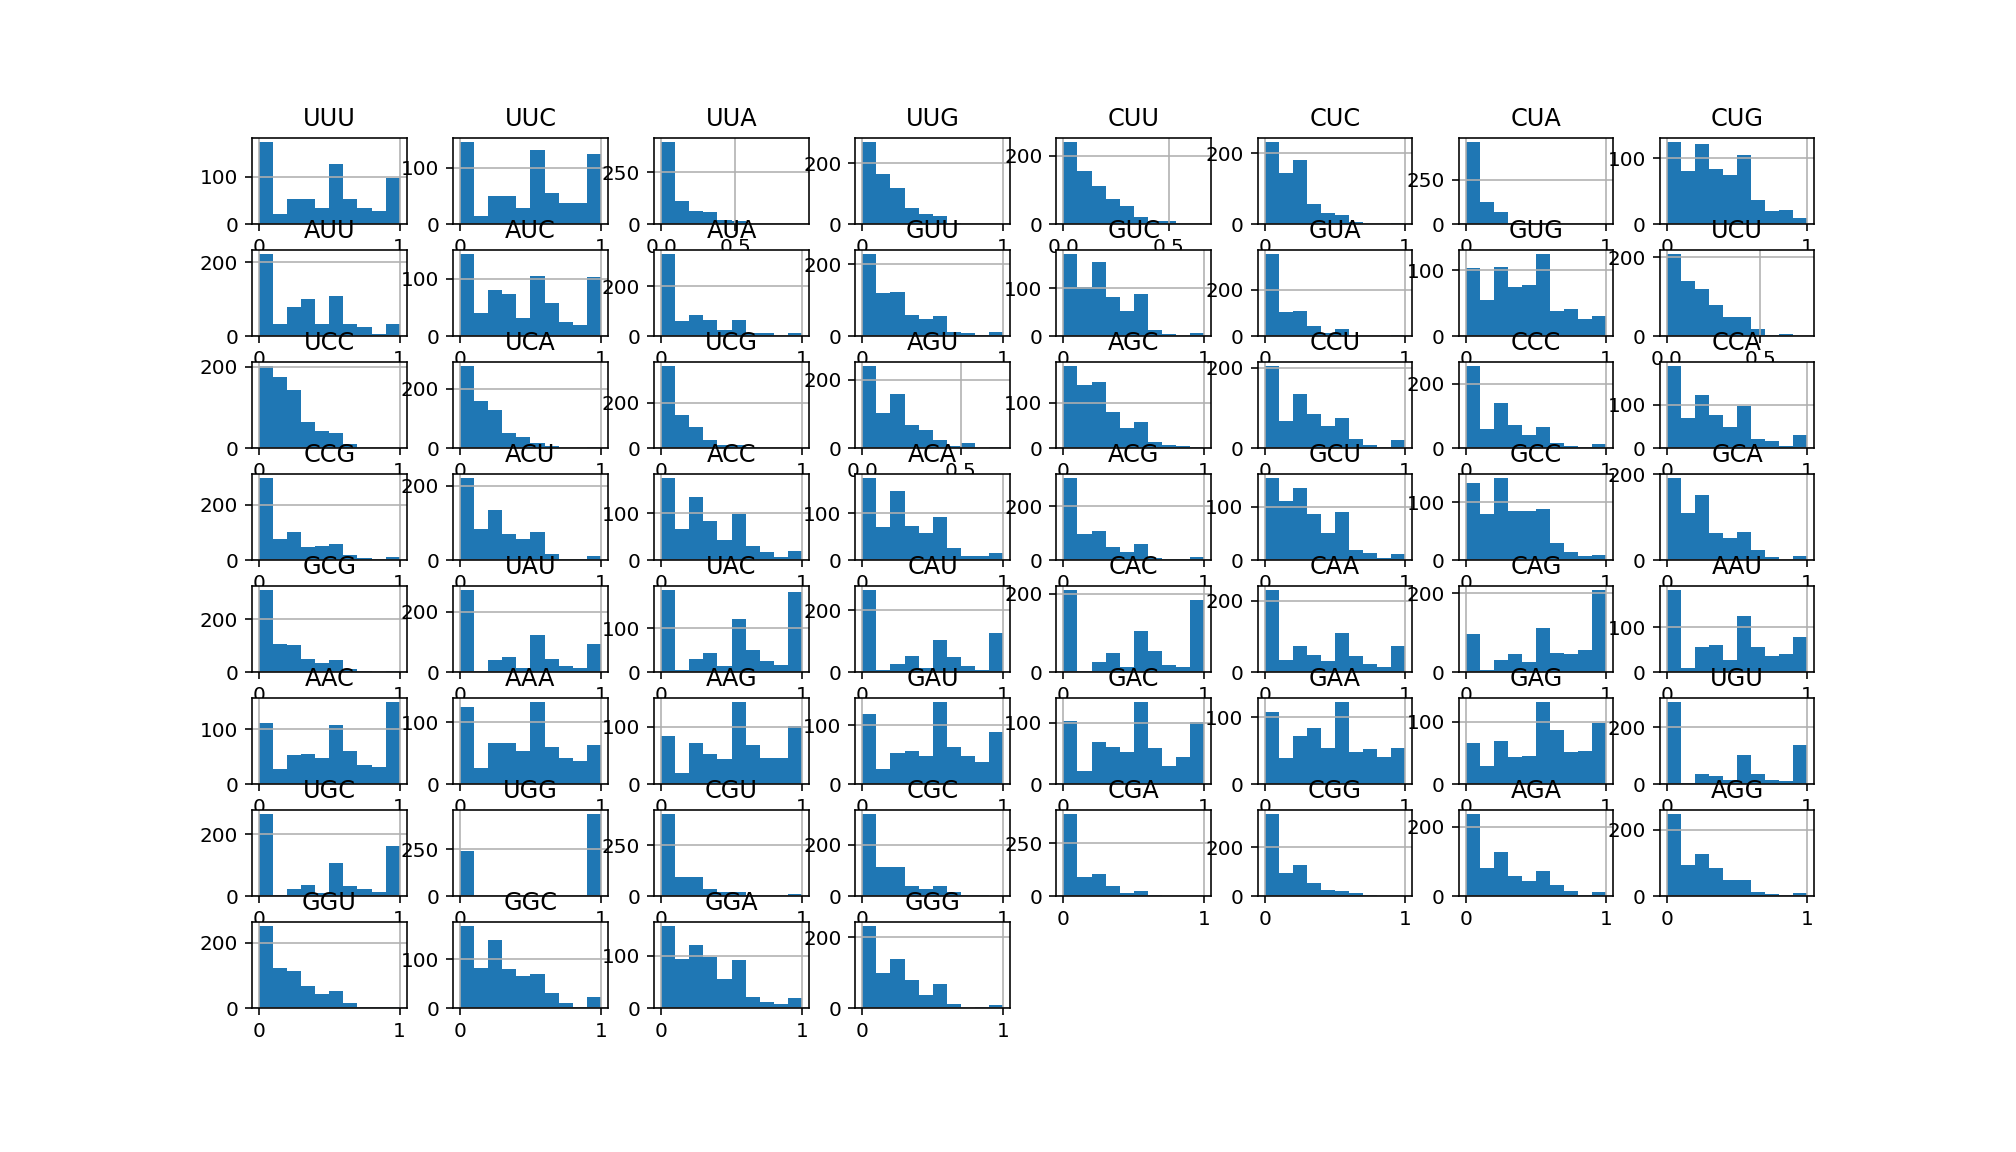

In [141]:
a_bias_num.hist(figsize=(14,8));

In [144]:
pd.set_option('display.max_columns', 64)
a_bias_num.describe()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,GUU,GUC,GUA,GUG,UCU,UCC,UCA,UCG,AGU,AGC,CCU,CCC,CCA,CCG,ACU,ACC,ACA,ACG,GCU,GCC,GCA,GCG,UAU,UAC,CAU,CAC,CAA,CAG,AAU,AAC,AAA,AAG,GAU,GAC,GAA,GAG,UGU,UGC,CGU,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.00000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.437889,0.491000,0.115660,0.165521,0.129478,0.179161,0.072016,0.335201,0.309778,0.432914,0.193605,0.218688,0.247552,0.132447,0.393906,0.166569,0.192078,0.154526,0.116475,0.141822,0.227049,0.262274,0.224791,0.293398,0.203241,0.234352,0.292837,0.281493,0.182429,0.276831,0.301062,0.242201,0.171017,0.364289,0.500896,0.392342,0.486177,0.352444,0.612000,0.429093,0.520536,0.445995,0.51845,0.483047,0.493250,0.441091,0.539649,0.382892,0.427479,0.117564,0.157299,0.116275,0.144087,0.240563,0.206435,0.195082,0.282984,0.295712,0.214370
std,0.343272,0.348738,0.155518,0.162522,0.127776,0.158285,0.102978,0.238071,0.284508,0.335973,0.241167,0.221457,0.204513,0.178431,0.268719,0.150498,0.168437,0.161612,0.150053,0.138164,0.192854,0.241480,0.231669,0.263926,0.235130,0.222976,0.251784,0.239982,0.220898,0.224822,0.223895,0.216570,0.202173,0.361441,0.386113,0.381363,0.396047,0.334733,0.348265,0.338021,0.344777,0.306155,0.31034,0.319860,0.320239,0.295987,0.299181,0.393153,0.403778,0.178797,0.189711,0.157404,0.176299,0.239102,0.205605,0.196614,0.243809,0.240957,0.205379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.154762,0.000000,0.000000,0.090909,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.250000,0.200000,0.30000,0.250000,0.250000,0.222222,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095455,0.111111,0.000000
50%,0.500000,0.500000,0.066667,0.133333,0.111111,0.166667,0.000000,0.333333,0.333333,0.400000,0.125000,0.166667,0.230769,0.000000,0.400000,0.142857,0.166667,0.125000,0.083333,0.125000,0.200000,0.250000,0.200000,0.250000,0.150000,0.200000,0.250000,0.250000,0.142857,0.250000,0.285714,0.200000,0.117647,0.333333,0.500000,0.333333,0.500000,0.333333,0.666667,0.444444,0.500000,0.473684,0.50000,0.500000,0.500000,0.428571,0.555556,0.333333,0.500000,0.000000,0.111111,0.000000,0.100000,0.200000,0.166667,0.166667,0.250000,0.272727,0.200000
75%,0.666667,0.750000,0.188988,0.250000,0.205263,0.272727,0.114379,0.500000,0.500000,0.666667,0.333333,0.333333,0.375000,0.250000,0.571429,0.250000,0.285714,0.250000,0.184659,0.222222,0.333333,0.400000,0.333333,0.500000,0.333333,0.375000,0.500000,0.428571,0.300000,0.400000,0.444444,0.375000,0.285714,0.666667,1.000000,0.666667,1.000000,0.600000,1.000000,0.666667,0.800000,0.666667,0.75000,0.714286,0.750000,0.666667,0.750000,0.666667,0.8

In [151]:
# normalize animal CUB data
# a_bias_norm = normalize(a_bias_num)
a_bias_norm = a_bias_num.to_numpy()
# a_bias_norm = standardize(a_bias_num)
print(a_bias_norm.shape)

# cluster with k-means
labels, centers = kmeans_sklearn(a_bias_norm, 3)

(675, 59)


In [153]:
# append cluster labels to visualization df
a_bias_2d["Cluster"] = labels
a_bias_2d["Cluster"] = a_bias_2d["Cluster"].apply(lambda x: 0 if x else 1)  # swap label numbers to match vertebrate labels

a_bias_2d.head()

,Dim1,Dim2,AccessionNum,SeqLen,Species,Taxon,Vertebrate,Cluster
0,-0.094550,-0.840267,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,1,0
1,-0.399652,0.107291,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,1,0
2,-0.121369,0.001907,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,1,0
3,0.681652,0.065340,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,1,0
4,1.109017,-0.085078,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,1,0


<IPython.core.display.Javascript object>


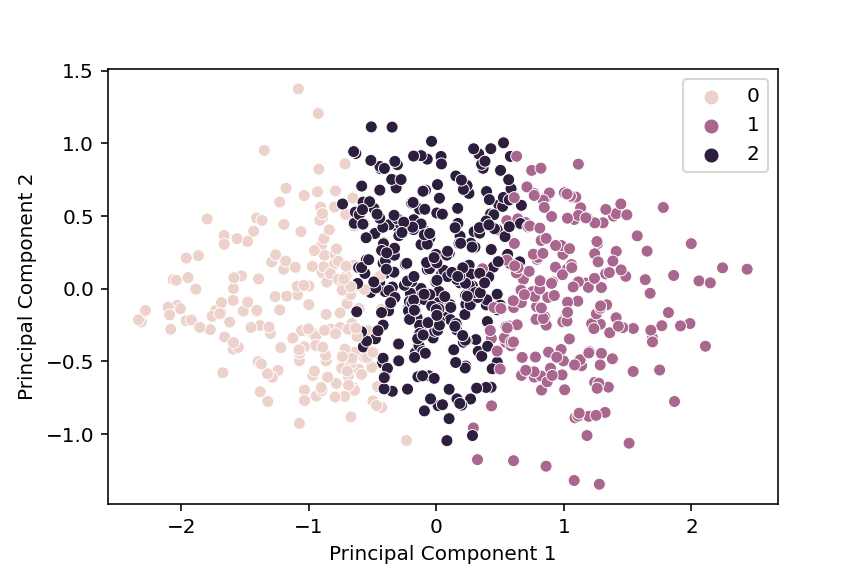

In [152]:
# visualize
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

Now we plot newly generated clusters next to known vertebrate/invertebrate identifiers. TODO: make these plots wider

<IPython.core.display.Javascript object>


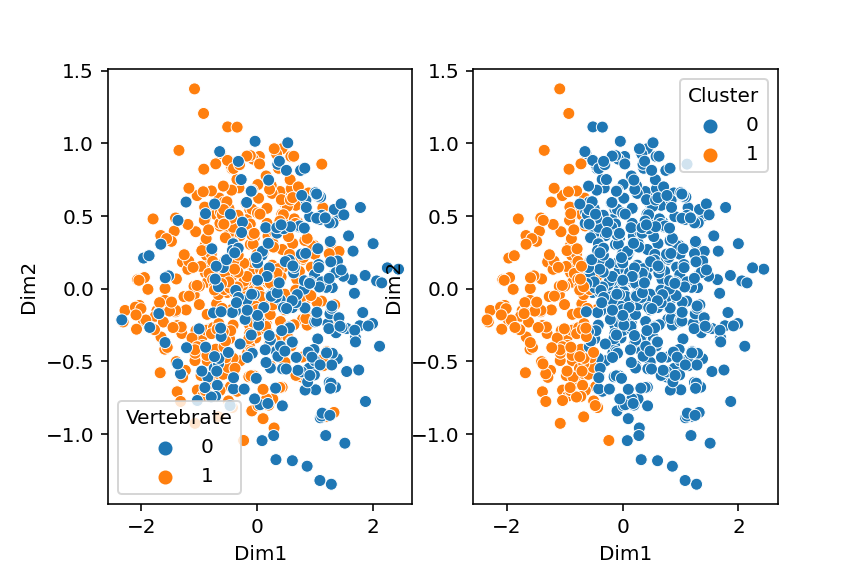

In [155]:
# https://www.tutorialspoint.com/how-do-i-plot-two-countplot-graphs-side-by-side-in-seaborn-using-matplotlib
f, axes = plt.subplots(1, 2)
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Vertebrate', ax=axes[0])
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Cluster', ax=axes[1]);

In [58]:
# summary table of known classification vs. newly found clusters
a_bias_2d.groupby(['Vertebrate', 'Cluster'])['Species'].count()

Vertebrate  Cluster
0           0          125
            1          132
1           0          165
            1          253
Name: Species, dtype: int64

50% of invertebrates are label 0, while 60% of vertebrates are label 0. This suggests we may be able to extract meaningful boundaries between vertebrates and invertebrates. Which leads us to ask:

### can we predict whether an organism is vertebrate or invertebrate?
(building a classifier)

In [35]:
# drop all columns except CUB and label (vertebrate)
a_class = a_bias.copy()  # a_bias.drop(columns=["UAA", "UAG", "UGA"])
a_class = a_class.drop(columns=["AccessionNum", "SeqLen", "Species", "Taxon"])
a_class.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG,Vertebrate
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,...,0.0,0.00,0.4,0.20,0.2,0.125,0.125000,0.375000,0.375,1
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,...,0.0,0.00,0.0,0.00,0.0,0.000,0.200000,0.000000,0.800,1
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,...,0.4,0.00,0.0,0.20,0.2,0.125,0.250000,0.375000,0.250,1
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,...,0.1,0.00,0.2,0.30,0.3,0.500,0.000000,0.500000,0.000,1
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,...,0.0,0.25,0.0,0.25,0.5,0.000,0.166667,0.333333,0.500,1


In [36]:
# separate data into test/train and validation sets
np.random.seed(888)
a_class_valid, a_class_tt = divide_data(a_class)

In [37]:
# cross-validation for model selection

# get all cv errors for each method
cv_errors = all_cv_errors(a_class_tt, ['neighbor', 'tree', 'forest']) # excluding 'SVM'

# store best method
best_method = cv_errors[0,0]
lowest_cv_err = cv_errors[0,1]

cv_errors

array([['neighbor', 0.25655737704918036],
       ['forest', 0.2631693989071038],
       ['tree', 0.3239617486338798]], dtype=object)

In [38]:
# print best model
print('best model')
print('method:  ', best_method)
print('error:   ', lowest_cv_err)

best model
method:   neighbor
error:    0.25655737704918036


In [39]:
# build best type of model
mod_animal = KNeighborsClassifier(n_neighbors = 9)
mod_animal.fit(a_class_tt.iloc[:,:-1], a_class_tt.iloc[:,-1]) # from all but the last column, predict last column

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [40]:
# validate the model
# compute validation error
val_preds = mod_animal.predict(a_class_valid.iloc[:,:-1])
val_error = classification_mse(val_preds, a_class_valid.iloc[:,-1])
print('validation error:           ', val_error)
print('best cross-validation error:', lowest_cv_err)

validation error:            0.22388059701492538
best cross-validation error: 0.25655737704918036


In our validation set, we predicted vertebrate vs. invertebrate correctly 78% of the time. Thus, CUB alone is a moderately useful in distinguishing between vertebrates and invertebrates.

## Identifying virus host from CUB
Pull in extra viral host data from: https://www.ncbi.nlm.nih.gov/genomes/GenomesGroup.cgi?taxid=10239&cmd=download2
(On https://www.ncbi.nlm.nih.gov/genome/viruses/, it's the Accession List of all viral genomes)

In [41]:
hosts = pd.read_csv("datasets/viral_hosts.csv", skiprows=[0])
hosts = hosts.drop(columns=["Neighbor", "Segment name", "Representative", "Selected lineage"])
hosts.head()

,Host,Taxonomy name
0,"human,vertebrates",Cowpox virus
1,"human,vertebrates",Cowpox virus
2,"human,vertebrates",Cowpox virus
3,"human,vertebrates",Cowpox virus
4,"human,vertebrates",Cowpox virus


In [42]:
hosts.shape

(246136, 2)

In [43]:
# remove duplicate entries for each virus
hosts = hosts.drop_duplicates(ignore_index=True)
print(hosts.shape)
hosts = hosts.dropna()
hosts.shape

(17116, 2)


(16095, 2)

In [44]:
hosts.head(10)

,Host,Taxonomy name
0,"human,vertebrates",Cowpox virus
1,"human,vertebrates",Monkeypox virus
2,"human,vertebrates",Monkeypox virus Zaire-96-I-16
3,"human,vertebrates",Vaccinia virus
4,"human,vertebrates",Vaccinia virus Copenhagen
5,"human,vertebrates",Vaccinia virus Ankara
6,"human,vertebrates",Vaccinia virus Tian Tan
7,"human,vertebrates",Rabbitpox virus
8,"human,vertebrates",Horsepox virus
9,"human,vertebrates",Buffalopox virus


In [45]:
# follow CUB dataset naming convention
hosts['Species'] = hosts['Taxonomy name'].apply(lambda x: x.replace(" ", "_"))

# column for whether human is host or not
hosts['Human_Host'] = hosts['Host'].apply(lambda x: "human" in x)
hosts.head()

,Host,Taxonomy name,Species,Human_Host
0,"human,vertebrates",Cowpox virus,Cowpox_virus,True
1,"human,vertebrates",Monkeypox virus,Monkeypox_virus,True
2,"human,vertebrates",Monkeypox virus Zaire-96-I-16,Monkeypox_virus_Zaire-96-I-16,True
3,"human,vertebrates",Vaccinia virus,Vaccinia_virus,True
4,"human,vertebrates",Vaccinia virus Copenhagen,Vaccinia_virus_Copenhagen,True


In [46]:
# join in host info where matches any viruses in the CUB dataset
# inner join -> only keep species w/ info in both datasets
virus_cub = pd.merge(bias_pd, hosts, on="Species")
virus_cub.shape

(4261, 71)

In [47]:
# 196 viruses w/ human host
human_sum = np.sum(virus_cub["Human_Host"])
human_sum

196

In [48]:
# keep equal numbers human and non-human viruses
# (otherwise non-human viruses overwhelm the dataset)
np.random.seed(888)
virus_human = virus_cub[virus_cub["Human_Host"]]
virus_non_human = virus_cub[~virus_cub["Human_Host"]]
virus_non_human = shuffle(virus_non_human).head(human_sum)  # keep random viruses - same amt as human viruses

virus_cub_short = pd.concat([virus_human, virus_non_human])
virus_cub_short.shape

(392, 71)

In [49]:
virus_cub_short.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,GGC,GGA,GGG,AccessionNum,SeqLen,Species,Taxon,Host,Taxonomy name,Human_Host
10,0.666667,0.333333,0.000000,0.428571,0.214286,0.000000,0.142857,0.214286,0.090909,0.545455,...,0.111111,0.444444,0.111111,GCF_000882815.3_ViralProj36615,10260,Zika_virus,viral,"human,invertebrates,vertebrates",Zika virus,True
16,0.500000,0.500000,0.000000,0.250000,0.500000,0.166667,0.000000,0.083333,0.285714,0.571429,...,0.200000,0.200000,0.200000,GCF_000848505.1_ViralProj14703,16506,Zaire_ebolavirus,viral,"human,vertebrates",Zaire ebolavirus,True
34,0.600000,0.400000,0.000000,0.636364,0.000000,0.000000,0.181818,0.181818,0.400000,0.400000,...,0.181818,0.636364,0.000000,GCF_000857725.1_ViralProj15284,10236,Yellow_fever_virus,viral,"human,invertebrates,vertebrates",Yellow fever virus,True
74,0.666667,0.333333,0.500000,0.250000,0.250000,0.000000,0.000000,0.000000,0.230769,0.307692,...,0.250000,0.250000,0.250000,GCF_002029635.1_ViralMultiSegProj379134,11673,Wyeomyia_orthobunyavirus,viral,"human,invertebrates",Wyeomyia orthobunyavirus,True
185,1.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.428571,0.428571,...,0.000000,1.000000,0.000000,GCF_000850885.1_ViralProj14831,13554,Western_equine_encephalitis_virus,viral,"human,invertebrates,vertebrates",Western equine encephalitis virus,True


In [50]:
# dataset for our classifier, with just CUB and Human_Host columns
virus_cub_short_num = virus_cub_short.drop(columns=["AccessionNum", "SeqLen", "Species",
                                                    "Taxon", "Host", "Taxonomy name"])
virus_cub_short_num.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG,Human_Host
10,0.666667,0.333333,0.000000,0.428571,0.214286,0.000000,0.142857,0.214286,0.090909,0.545455,...,0.090909,0.000000,0.181818,0.363636,0.272727,0.333333,0.111111,0.444444,0.111111,True
16,0.500000,0.500000,0.000000,0.250000,0.500000,0.166667,0.000000,0.083333,0.285714,0.571429,...,0.000000,0.000000,0.333333,0.333333,0.000000,0.400000,0.200000,0.200000,0.200000,True
34,0.600000,0.400000,0.000000,0.636364,0.000000,0.000000,0.181818,0.181818,0.400000,0.400000,...,0.153846,0.153846,0.000000,0.384615,0.230769,0.181818,0.181818,0.636364,0.000000,True
74,0.666667,0.333333,0.500000,0.250000,0.250000,0.000000,0.000000,0.000000,0.230769,0.307692,...,0.000000,0.200000,0.000000,0.600000,0.200000,0.250000,0.250000,0.250000,0.250000,True
185,1.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.428571,0.428571,...,0.100000,0.000000,0.300000,0.500000,0.100000,0.000000,0.000000,1.000000,0.000000,True


### and now, we build the classifier...

In [51]:
# separate data into test/train and validation sets
np.random.seed(888)
virus_valid, virus_tt = divide_data(virus_cub_short_num)

In [52]:
# cross-validation for model selection

# get all cv errors for each method
cv_errors = all_cv_errors(virus_tt, ['neighbor', 'tree', 'forest', 'SVM'])

# store best method
best_method = cv_errors[0,0]
lowest_cv_err = cv_errors[0,1]

cv_errors

array([['neighbor', 0.3681746031746032],
       ['SVM', 0.37658730158730164],
       ['forest', 0.425],
       ['tree', 0.44722222222222224]], dtype=object)

In [53]:
# print best model
print('best model')
print('method:  ', best_method)
print('error:   ', lowest_cv_err)

best model
method:   neighbor
error:    0.3681746031746032


In [54]:
# build best type of model
# mod_virus = KNeighborsClassifier(n_neighbors = 9)
mod_virus = SVC(kernel="sigmoid")
mod_virus.fit(virus_tt.iloc[:,:-1], virus_tt.iloc[:,-1]) # from all but the last column, predict last column

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
# validate the model
# compute validation error
val_preds = mod_virus.predict(virus_valid.iloc[:,:-1])
val_error = classification_mse(val_preds, virus_valid.iloc[:,-1])
print('validation error:           ', val_error)
print('best cross-validation error:', lowest_cv_err)

validation error:            0.28205128205128205
best cross-validation error: 0.3681746031746032


In our validation set, we correctly predicted whether a virus is hosted by humans or not 72% of the time. Thus, our model performs moderately well, and certainly better than random chance. The moderate success of this classifier  suggests that CUB may be a useful predictor of whether a virus may infect humans, alongside other factors. Potential applications could include incorporating CUB as a factor in models that predict emerging viral threats to the human species.

### Discussion

- many other potential questions to ask of this data. but data is especially even more useful when joined with other datasets. (such as how I joined with the dataset of viral hosts)
- code developed for this project could be useful to other researchers - it could be a great start to a package for scraping the NCBI RefSeq database and performing any given operation on each genome (or a selected list of species' genomes)
- the dataset created from the project (CUB of thousands of animals, plants, and viruses) could be published on a data-sharing website, both for the use of bioinformaticians to explore more about the usefulness of CUB, and for the use of machine learners who are always looking for good clean datasets to work with
- scraping virus data is still ongoing—my program has been running for well over 48 hours (of total runtime, with breaks in between due to getting temporarily banned from the NCBI servers, closing my laptop, etc.)

**Relevant Papers:**
- Bahir, I., Fromer, M., Prat, Y. & Linial, M. Viral adaptation to host: a proteome-based analysis of codon usage and amino acid preferences. Mol. Syst. Biol. 5, 311 (2009). https://doi-org.libproxy.smith.edu/10.1038/msb.2009.71.
- Chen, F., Wu, P., Deng, S. et al. Dissimilation of synonymous codon usage bias in virus–host coevolution due to translational selection. Nat. Ecol. Evol. 4, 589–600 (2020). https://doi-org.libproxy.smith.edu/10.1038/s41559-020-1124-7.
- Gong, Y., Wen, G., Jiang, J. and Xie, F. (2020), Codon bias analysis may be insufficient for identifying host(s) of a novel virus. J Med Virol, 92: 1434-1436. https://doi.org/10.1002/jmv.25977
- Hershberg, R. & Petrov, D. A. Selection on codon bias. Annu. Rev. Genet. 42, 287–299 (2008). https://doi.org/10.1146/annurev.genet.42.110807.091442.
- Jenkins, G. M. & Holmes, E. C. The extent of codon usage bias in human RNA viruses and its evolutionary origin. Virus Res. 92, 1–7 (2003). https://doi.org/10.1016/S0168-1702(02)00309-X.
- Yi, K., Kim, S.Y., Bleazard, T. et al. Mutational spectrum of SARS-CoV-2 during the global pandemic. Exp. Mol. Med. 53, 1229–1237 (2021). https://doi-org.libproxy.smith.edu/10.1038/s12276-021-00658-z. 